In [2]:
# ========== 参数配置区（在这里修改） ==========
# 请在运行前修改以下参数

# 搜索空间设置
SEARCH_SPACE = "micro"  # 选择 "micro" 或 "macro"

# 任务设置
TASK = "normal"  # 选择 "autoencoder", "segmentsemantic", 或 "normal"

# 排名设置
# 正数：第 N 名（性能最好的）
# 负数：倒数第 N 名（性能最差的）
RANK = 1  # 例如: 1 = 第1名, -1 = 倒数第1名, 5 = 第5名, -5 = 倒数第5名

# 数据设置
BATCH_SIZE = 8  # 每个 batch 的样本数
NUM_BATCHES = 2  # 使用多少个 batch 来计算统计信息



Step 1: 初始化环境
NASLib 路径: D:\Dataset\MCUFlowNet\NASLib
✓ 环境初始化完成

Step 2: 查找目标架构
✓ 已加载数据库: transnas-bench_v10141024.pth
搜索空间: micro
任务: normal
GT 指标: valid_ssim
选择: 正数第 1 名

正在遍历 4096 个架构...
✓ 成功查询 4096 个架构

【选中架构】 to 1 rank
  架构字符串: 64-41414-1_30_123
  GT 分数 (valid_ssim): 0.587287

Step 3: 创建模型
op_indices: [1, 3, 0, 1, 2, 3]
✓ 模型已创建并移至 cuda

Step 4: 准备数据
✓ 已准备 2 个 batch，每个 batch 大小: 8

Step 5: 收集梯度和特征图
✓ 已收集 34 层的梯度和特征图

Step 6: 计算层级统计信息
✓ 已完成 34 层的统计分析
✓ 其中有效层: 28, 无效层（梯度方差=0）: 6

【无效层列表】
  1. 1
  2. 1
  3. 1
  4. 1
  5. 1
  6. 1

Step 6.5: 每层统计信息详情

层编号    状态     层名称                                         log(Stab)    log(Grad)    log(SNR)     log(Psi)     log(Final)  
----------------------------------------------------------------------------------------------------------------------------------
0      ✓      0                                           15.9713      1.1439       1.3315       5.5294       21.5008     
1      ✓      1                                           18.5622

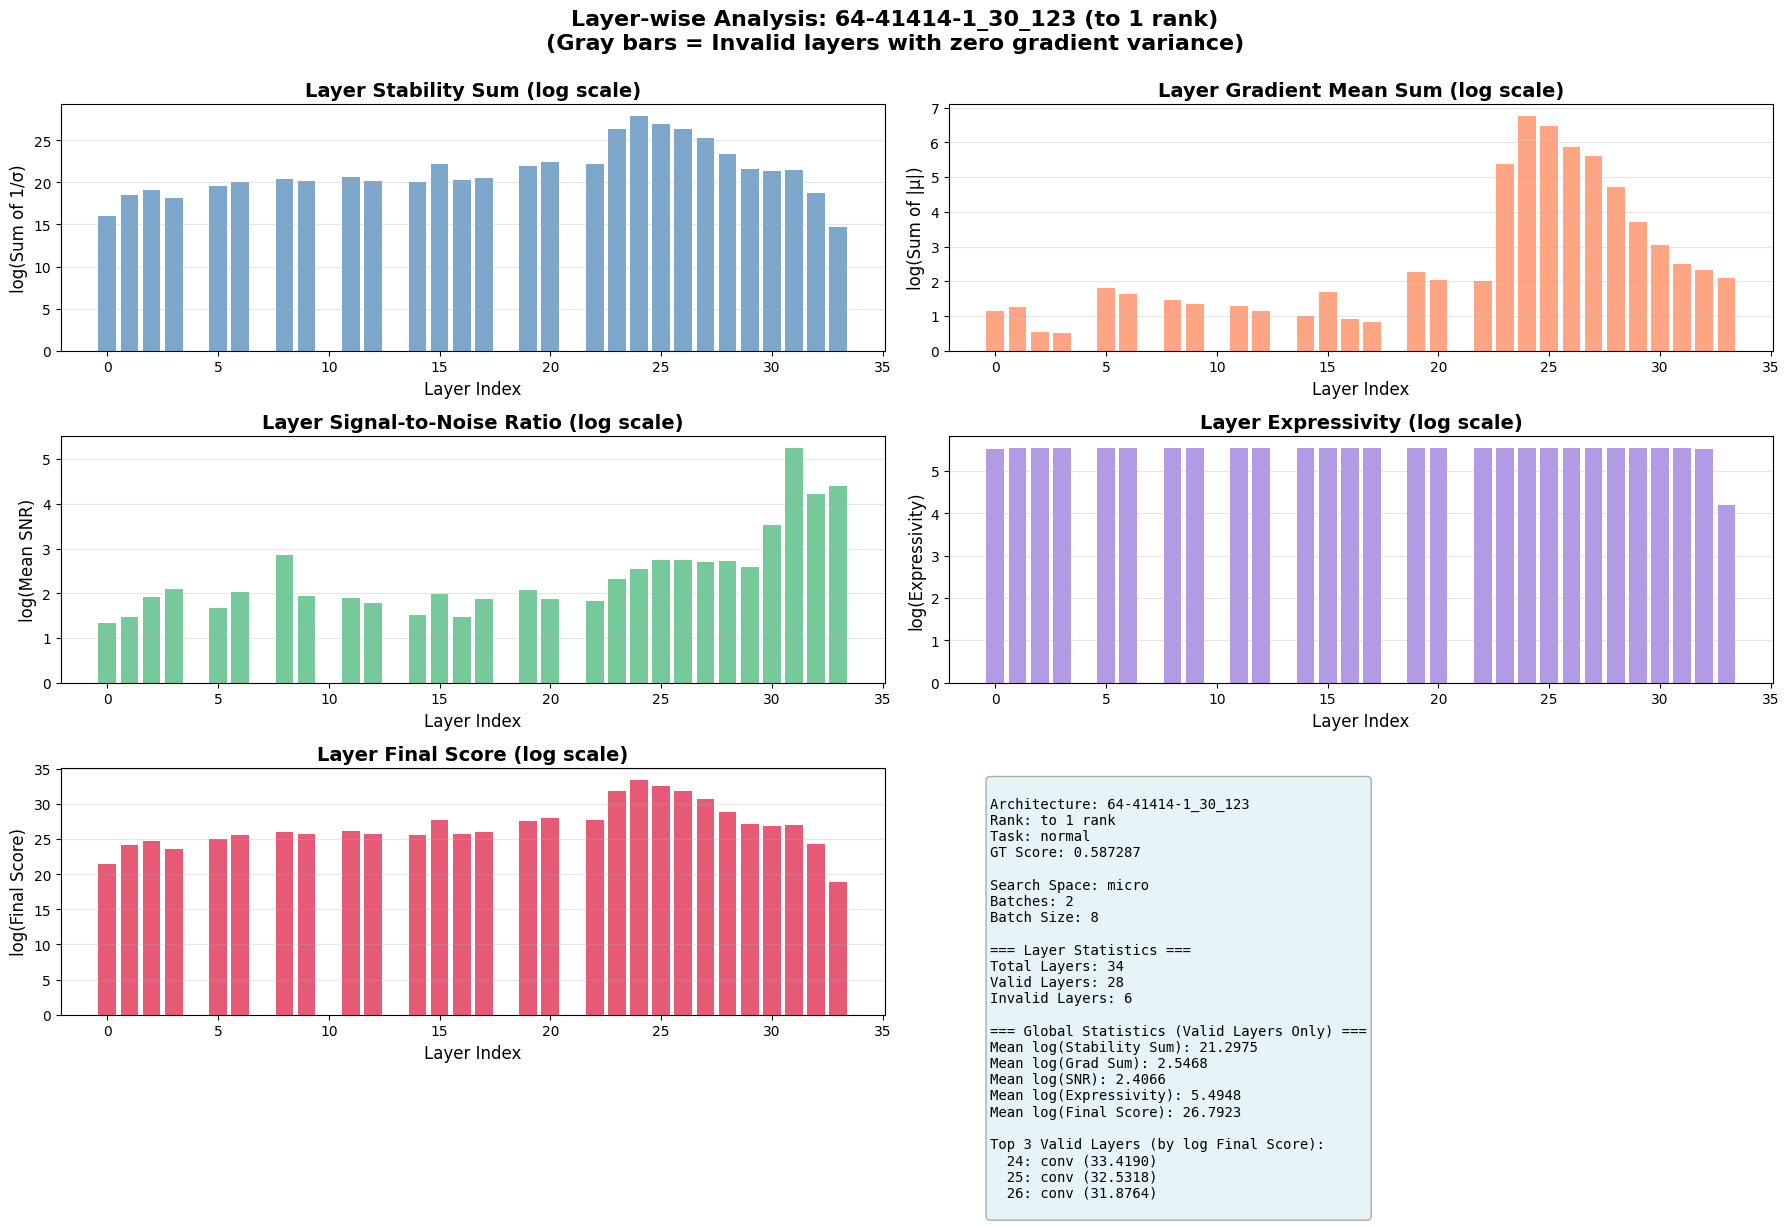

✓ 可视化完成

分析完成！


In [ ]:


import sys
from pathlib import Path
import importlib.util
import numpy as np
import torch
import torch.nn as nn
import argparse
import itertools
import matplotlib.pyplot as plt
import math
# 设备设置
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # 计算设备
# ========== Step 1: 路径设置和 API 加载 ==========
print("=" * 80)
print("Step 1: 初始化环境")
print("=" * 80)

# 设置路径
CURRENT_DIR = Path().resolve()
ROOT_DIR = CURRENT_DIR.parent if CURRENT_DIR.name == "proxy_TransNAS" else CURRENT_DIR
NASLIB_ROOT = ROOT_DIR / "NASLib"
sys.path.insert(0, str(NASLIB_ROOT))

print(f"NASLib 路径: {NASLIB_ROOT}")

# 动态加载 TransNAS-Bench API
api_path = NASLIB_ROOT / "naslib" / "search_spaces" / "transbench101" / "api.py"
spec = importlib.util.spec_from_file_location("transbench_api", api_path)
module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(module)
TransNASBenchAPI = module.TransNASBenchAPI

# 动态加载 graph 模块
graph_path = NASLIB_ROOT / "naslib" / "search_spaces" / "transbench101" / "graph.py"
spec = importlib.util.spec_from_file_location("transbench_graph", graph_path)
graph_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(graph_module)
Metric = graph_module.Metric

# 加载工具函数
from naslib import utils
from naslib.search_spaces.transbench101.conversions import (
    convert_op_indices_micro_to_str,
    convert_op_indices_macro_to_str,
)

print("✓ 环境初始化完成\n")

# ========== Step 2: 查找目标架构 ==========
print("=" * 80)
print("Step 2: 查找目标架构")
print("=" * 80)

# 加载数据库
DATA_ROOT = NASLIB_ROOT / "naslib" / "data"
pth_path = DATA_ROOT / "transnas-bench_v10141024.pth"
if not pth_path.exists():
    pth_path = Path("transnas-bench_v10141024.pth")
    assert pth_path.exists(), f"找不到数据库文件: {pth_path}"

api = TransNASBenchAPI(str(pth_path))
print(f"✓ 已加载数据库: {pth_path.name}")

# 确定 GT 指标名称
if TASK in ["class_scene", "class_object", "jigsaw"]:
    metric_name = "valid_top1"
elif TASK == "room_layout":
    metric_name = "valid_neg_loss"
elif TASK == "segmentsemantic":
    metric_name = "valid_acc"
else:  # autoencoder, normal
    metric_name = "valid_ssim"

print(f"搜索空间: {SEARCH_SPACE}")
print(f"任务: {TASK}")
print(f"GT 指标: {metric_name}")
print(f"选择: {'倒数' if RANK < 0 else '正数'}第 {abs(RANK)} 名\n")

# 遍历所有架构并收集分数
arch_scores = []
all_archs = api.all_arch_dict[SEARCH_SPACE]
print(f"正在遍历 {len(all_archs)} 个架构...")

for arch_str in all_archs:
    try:
        gt_score = api.get_single_metric(arch_str, TASK, metric_name, mode="final")
        arch_scores.append((arch_str, gt_score))
    except:
        continue

print(f"✓ 成功查询 {len(arch_scores)} 个架构\n")

# 排序并选择目标架构
arch_scores_sorted = sorted(arch_scores, key=lambda x: x[1], reverse=True)

if RANK > 0:  # 正数第 N 名
    target_arch_str, target_gt = arch_scores_sorted[RANK - 1]
    rank_desc = f"top {RANK} rank"
else:  # 倒数第 N 名
    target_arch_str, target_gt = arch_scores_sorted[RANK]
    rank_desc = f"last {abs(RANK)} rank"

print(f"【选中架构】 {rank_desc}")
print(f"  架构字符串: {target_arch_str}")
print(f"  GT 分数 ({metric_name}): {target_gt:.6f}\n")

# ========== Step 3: 创建模型 ==========
print("=" * 80)
print("Step 3: 创建模型")
print("=" * 80)

# 动态加载搜索空间类
TransBench101SearchSpaceMicro = graph_module.TransBench101SearchSpaceMicro
TransBench101SearchSpaceMacro = graph_module.TransBench101SearchSpaceMacro

# 创建搜索空间对象
if SEARCH_SPACE == "micro":
    if TASK == "segmentsemantic":
        ss = TransBench101SearchSpaceMicro(dataset=TASK, create_graph=True, n_classes=17)
    else:
        ss = TransBench101SearchSpaceMicro(dataset=TASK, create_graph=True)
else:
    ss = TransBench101SearchSpaceMacro(dataset=TASK, create_graph=True)

# 解析架构字符串
if SEARCH_SPACE == "micro":
    parts = target_arch_str.split("-")
    config_part = parts[-1]
    config_parts = config_part.split("_")
    
    op_indices = []
    op_indices.append(int(config_parts[0]))
    for digit in config_parts[1]:
        op_indices.append(int(digit))
    for digit in config_parts[2]:
        op_indices.append(int(digit))
else:
    parts = target_arch_str.split("-")
    ops_string = parts[1]
    op_indices = [int(d) for d in ops_string]
    while len(op_indices) < 6:
        op_indices.append(0)

print(f"op_indices: {op_indices}")

# 设置架构并创建模型
ss.set_op_indices(op_indices)
ss.parse()
model = ss.to(DEVICE)
model.train()

print(f"✓ 模型已创建并移至 {DEVICE}\n")

# ========== Step 4: 准备数据 ==========
print("=" * 80)
print("Step 4: 准备数据")
print("=" * 80)

data_root = NASLIB_ROOT / "naslib" / "data"
get_train_val_loaders = utils.get_train_val_loaders

search_cfg = argparse.Namespace(
    seed=42,
    batch_size=BATCH_SIZE,
    train_portion=0.7,
)
config = argparse.Namespace(
    data=str(data_root),
    dataset=TASK,
    search=search_cfg,
)

train_loader, _, _, _, _ = get_train_val_loaders(config)
train_batches = list(itertools.islice(iter(train_loader), NUM_BATCHES))

print(f"✓ 已准备 {len(train_batches)} 个 batch，每个 batch 大小: {BATCH_SIZE}\n")

# 准备损失函数
if TASK in ["autoencoder", "normal"]:
    loss_fn = torch.nn.L1Loss()
elif TASK == "segmentsemantic":
    loss_fn = torch.nn.CrossEntropyLoss()
else:
    loss_fn = torch.nn.CrossEntropyLoss()

loss_fn = loss_fn.to(DEVICE)

# ========== Step 5: 收集梯度和特征图 ==========
print("=" * 80)
print("Step 5: 收集梯度和特征图")
print("=" * 80)

raw_grads = {}
batch_features = {}
features_dict = {}

def get_feature_hook(name):
    """捕获特征图的 Hook"""
    def hook(module, inputs_hook, output_hook):
        out = output_hook.detach()
        if out.dim() == 4 and (out.shape[2] > 16 or out.shape[3] > 16):
            out = torch.nn.functional.adaptive_avg_pool2d(out, (16, 16))
        features_dict[name] = out
    return hook

hooks = []
for name, mod in model.named_modules():
    if isinstance(mod, (nn.Conv2d, nn.Linear)):
        hooks.append(mod.register_forward_hook(get_feature_hook(name)))

# 遍历 batch 收集数据
for batch_idx, (data, label) in enumerate(train_batches):
    model.zero_grad()
    data = data.to(DEVICE)
    label = label.to(DEVICE)
    
    if TASK == "segmentsemantic":
        label = label.long()
    
    # 前向和反向传播
    logits = model(data)
    loss = loss_fn(logits, label)
    loss.backward()
    
    # 收集梯度
    for name, mod in model.named_modules():
        if isinstance(mod, (torch.nn.Conv2d, torch.nn.Linear)) and mod.weight.grad is not None:
            g = mod.weight.grad.detach().reshape(-1)
            if name not in raw_grads:
                raw_grads[name] = []
            raw_grads[name].append(g.cpu())
    
    # 收集特征图
    for name, mod in model.named_modules():
        if isinstance(mod, (nn.Conv2d, nn.Linear)) and name in features_dict:
            fmap = features_dict[name]
            if name not in batch_features:
                batch_features[name] = []
            batch_features[name].append(fmap.cpu())

# 移除 Hooks
for h in hooks:
    h.remove()

print(f"✓ 已收集 {len(raw_grads)} 层的梯度和特征图\n")

# ========== Step 6: 计算层级统计信息 ==========
print("=" * 80)
print("Step 6: 计算层级统计信息")
print("=" * 80)

layer_stats = {}
invalid_layers = []  # 记录无效层（梯度方差为0的层）

for name, grads_list in raw_grads.items():
    # Stack 梯度
    grads = torch.stack(grads_list)  # (Num_Batches, P)
    
    # 梯度均值和标准差
    grad_mean = torch.mean(grads, dim=0)  # (P,)
    grad_std = torch.std(grads, dim=0)    # (P,)
    
    # 【关键修改】检查是否所有梯度方差都为0
    if torch.all(grad_std == 0):
        # 如果梯度方差全为0，这一层是无效层，所有统计数据置为0
        layer_stats[name] = {
            'log_stability_sum': 0.0,
            'log_grad_mean_sum': 0.0,
            'log_mean_snr': 0.0,
            'log_psi': 0.0,
            'log_final_score': 0.0,
            'is_valid': False  # 标记为无效层
        }
        invalid_layers.append(name)
        continue  # 跳过后续计算
    
    # 【标记为有效层】
    # 1. 稳定性倒数和（Sum of 1/σ），只对非零方差计算
    stability_scores = torch.zeros_like(grad_std)
    non_zero_mask = (grad_std != 0)
    stability_scores[non_zero_mask] = 1.0 / grad_std[non_zero_mask]
    stability_sum = torch.sum(stability_scores).item()
    log_stability_sum = math.log(stability_sum) if stability_sum > 0 else 0.0
    
    # 2. 梯度均值和（Sum of |μ|）
    grad_mean_sum = torch.sum(torch.abs(grad_mean)).item()
    log_grad_mean_sum = math.log(grad_mean_sum) if grad_mean_sum > 0 else 0.0
    
    # 3. 信噪比均值（Mean SNR = |μ|/σ），只对非零方差计算
    snr = torch.zeros_like(grad_mean)
    snr[non_zero_mask] = torch.abs(grad_mean[non_zero_mask]) / grad_std[non_zero_mask]
    mean_snr = torch.mean(snr[non_zero_mask]).item() if non_zero_mask.any() else 0.0
    log_mean_snr = math.log(mean_snr) if mean_snr > 0 else 0.0
    
    # 4. 表达能力（Expressivity）
    psi_l = 1.0
    
    if name in batch_features:
        module = dict(model.named_modules())[name]
        psi_sum = 0.0
        valid_batches = 0
        
        for fmap in batch_features[name]:
            fmap = fmap.to(DEVICE)
            bin_map = (fmap > 0).float()  # 二值化
            
            B = bin_map.size(0)
            flat_codes = bin_map.view(B, -1)
            neuron_codes = flat_codes.t()
            unique_codes = torch.unique(neuron_codes, dim=0)
            psi_sum += float(unique_codes.size(0))
            valid_batches += 1
        
        if valid_batches > 0:
            psi_l = psi_sum / valid_batches
    
    log_psi = math.log(psi_l) if psi_l > 0 else 0.0
    
    # 5. 最终得分（Final Score = Stability × Expressivity）
    final_score = stability_sum * psi_l
    log_final_score = math.log(final_score) if final_score > 0 else 0.0
    
    # 保存统计信息
    layer_stats[name] = {
        'log_stability_sum': log_stability_sum,
        'log_grad_mean_sum': log_grad_mean_sum,
        'log_mean_snr': log_mean_snr,
        'log_psi': log_psi,
        'log_final_score': log_final_score,
        'is_valid': True  # 标记为有效层
    }

print(f"✓ 已完成 {len(layer_stats)} 层的统计分析")
print(f"✓ 其中有效层: {len(layer_stats) - len(invalid_layers)}, 无效层（梯度方差=0）: {len(invalid_layers)}\n")

if invalid_layers:
    print("【无效层列表】")
    for idx, name in enumerate(invalid_layers, 1):
        short_name = name.split('.')[-1] if '.' in name else name
        print(f"  {idx}. {short_name}")
    print()

# ========== Step 6.5: 输出每一层的详细统计信息 ==========
print("=" * 80)
print("Step 6.5: 每层统计信息详情")
print("=" * 80)
print()

# 打印表头
print(f"{'层编号':<6} {'状态':<6} {'层名称':<43} {'log(Stab)':<12} {'log(Grad)':<12} {'log(SNR)':<12} {'log(Psi)':<12} {'log(Final)':<12}")
print("-" * 130)

# 遍历所有层并打印
layer_names = list(layer_stats.keys())
for idx, name in enumerate(layer_names):
    stats = layer_stats[name]
    # 缩短层名
    short_name = name.split('.')[-1] if '.' in name else name
    if len(short_name) > 41:
        short_name = short_name[:38] + "..."
    
    # 状态标记
    status = "✓" if stats['is_valid'] else "✗"
    
    print(f"{idx:<6} {status:<6} {short_name:<43} "
          f"{stats['log_stability_sum']:<12.4f} "
          f"{stats['log_grad_mean_sum']:<12.4f} "
          f"{stats['log_mean_snr']:<12.4f} "
          f"{stats['log_psi']:<12.4f} "
          f"{stats['log_final_score']:<12.4f}")

print("-" * 130)
print(f"总层数: {len(layer_stats)} (有效层: {len(layer_stats) - len(invalid_layers)}, 无效层: {len(invalid_layers)})\n")

# 【关键修改】只对有效层计算全局统计
valid_layer_names = [name for name in layer_names if layer_stats[name]['is_valid']]

if valid_layer_names:
    log_stability_sums = [layer_stats[name]['log_stability_sum'] for name in valid_layer_names]
    log_grad_mean_sums = [layer_stats[name]['log_grad_mean_sum'] for name in valid_layer_names]
    log_mean_snrs = [layer_stats[name]['log_mean_snr'] for name in valid_layer_names]
    log_psis = [layer_stats[name]['log_psi'] for name in valid_layer_names]
    log_final_scores = [layer_stats[name]['log_final_score'] for name in valid_layer_names]
    
    print("【全局统计（仅有效层）】")
    print(f"  Mean log(Stability Sum): {np.mean(log_stability_sums):.4f} (std: {np.std(log_stability_sums):.4f})")
    print(f"  Mean log(Grad Sum):      {np.mean(log_grad_mean_sums):.4f} (std: {np.std(log_grad_mean_sums):.4f})")
    print(f"  Mean log(SNR):           {np.mean(log_mean_snrs):.4f} (std: {np.std(log_mean_snrs):.4f})")
    print(f"  Mean log(Expressivity):  {np.mean(log_psis):.4f} (std: {np.std(log_psis):.4f})")
    print(f"  Mean log(Final Score):   {np.mean(log_final_scores):.4f} (std: {np.std(log_final_scores):.4f})")
    print()
    
    # 显示得分最高和最低的层（仅有效层）
    print("【得分最高的 3 层（仅有效层）】")
    valid_indices = [layer_names.index(name) for name in valid_layer_names]
    valid_scores = [layer_stats[name]['log_final_score'] for name in valid_layer_names]
    top_3_valid_indices = np.argsort(valid_scores)[-3:][::-1]
    
    for rank, valid_idx in enumerate(top_3_valid_indices, 1):
        name = valid_layer_names[valid_idx]
        original_idx = layer_names.index(name)
        short_name = name.split('.')[-1] if '.' in name else name
        print(f"  {rank}. Layer {original_idx}: {short_name} (log Final Score: {valid_scores[valid_idx]:.4f})")
    
    print()
    print("【得分最低的 3 层（仅有效层）】")
    bottom_3_valid_indices = np.argsort(valid_scores)[:3]
    for rank, valid_idx in enumerate(bottom_3_valid_indices, 1):
        name = valid_layer_names[valid_idx]
        original_idx = layer_names.index(name)
        short_name = name.split('.')[-1] if '.' in name else name
        print(f"  {rank}. Layer {original_idx}: {short_name} (log Final Score: {valid_scores[valid_idx]:.4f})")
else:
    print("【警告】所有层都是无效层！")
    log_stability_sums = [0.0] * len(layer_names)
    log_grad_mean_sums = [0.0] * len(layer_names)
    log_mean_snrs = [0.0] * len(layer_names)
    log_psis = [0.0] * len(layer_names)
    log_final_scores = [0.0] * len(layer_names)

print("\n")

# ========== Step 7: 可视化 ==========
print("=" * 80)
print("Step 7: 可视化")
print("=" * 80)

fig = plt.figure(figsize=(18, 12))

# 准备数据（包含所有层，但用颜色区分有效/无效）
layer_names_short = [name.split('.')[-1] if '.' in name else name for name in layer_names]

# 为所有层准备数据
all_log_stability_sums = [layer_stats[name]['log_stability_sum'] for name in layer_names]
all_log_grad_mean_sums = [layer_stats[name]['log_grad_mean_sum'] for name in layer_names]
all_log_mean_snrs = [layer_stats[name]['log_mean_snr'] for name in layer_names]
all_log_psis = [layer_stats[name]['log_psi'] for name in layer_names]
all_log_final_scores = [layer_stats[name]['log_final_score'] for name in layer_names]

# 颜色：有效层用蓝色，无效层用灰色
colors = ['steelblue' if layer_stats[name]['is_valid'] else 'lightgray' for name in layer_names]
colors_coral = ['coral' if layer_stats[name]['is_valid'] else 'lightgray' for name in layer_names]
colors_green = ['mediumseagreen' if layer_stats[name]['is_valid'] else 'lightgray' for name in layer_names]
colors_purple = ['mediumpurple' if layer_stats[name]['is_valid'] else 'lightgray' for name in layer_names]
colors_red = ['crimson' if layer_stats[name]['is_valid'] else 'lightgray' for name in layer_names]

# 子图1：稳定性倒数和（log）
ax1 = plt.subplot(3, 2, 1)
ax1.bar(range(len(layer_names)), all_log_stability_sums, color=colors, alpha=0.7)
ax1.set_xlabel('Layer Index', fontsize=12)
ax1.set_ylabel('log(Sum of 1/σ)', fontsize=12)
ax1.set_title('Layer Stability Sum (log scale)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# 子图2：梯度均值和（log）
ax2 = plt.subplot(3, 2, 2)
ax2.bar(range(len(layer_names)), all_log_grad_mean_sums, color=colors_coral, alpha=0.7)
ax2.set_xlabel('Layer Index', fontsize=12)
ax2.set_ylabel('log(Sum of |μ|)', fontsize=12)
ax2.set_title('Layer Gradient Mean Sum (log scale)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# 子图3：信噪比（log）
ax3 = plt.subplot(3, 2, 3)
ax3.bar(range(len(layer_names)), all_log_mean_snrs, color=colors_green, alpha=0.7)
ax3.set_xlabel('Layer Index', fontsize=12)
ax3.set_ylabel('log(Mean SNR)', fontsize=12)
ax3.set_title('Layer Signal-to-Noise Ratio (log scale)', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# 子图4：表达能力（log）
ax4 = plt.subplot(3, 2, 4)
ax4.bar(range(len(layer_names)), all_log_psis, color=colors_purple, alpha=0.7)
ax4.set_xlabel('Layer Index', fontsize=12)
ax4.set_ylabel('log(Expressivity)', fontsize=12)
ax4.set_title('Layer Expressivity (log scale)', fontsize=14, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# 子图5：最终得分（log）
ax5 = plt.subplot(3, 2, 5)
ax5.bar(range(len(layer_names)), all_log_final_scores, color=colors_red, alpha=0.7)
ax5.set_xlabel('Layer Index', fontsize=12)
ax5.set_ylabel('log(Final Score)', fontsize=12)
ax5.set_title('Layer Final Score (log scale)', fontsize=14, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)

# 子图6：汇总信息
ax6 = plt.subplot(3, 2, 6)
ax6.axis('off')

if valid_layer_names:
    summary_text = f"""
Architecture: {target_arch_str}
Rank: {rank_desc}
Task: {TASK}
GT Score: {target_gt:.6f}

Search Space: {SEARCH_SPACE}
Batches: {NUM_BATCHES}
Batch Size: {BATCH_SIZE}

=== Layer Statistics ===
Total Layers: {len(layer_stats)}
Valid Layers: {len(valid_layer_names)}
Invalid Layers: {len(invalid_layers)}

=== Global Statistics (Valid Layers Only) ===
Mean log(Stability Sum): {np.mean(log_stability_sums):.4f}
Mean log(Grad Sum): {np.mean(log_grad_mean_sums):.4f}
Mean log(SNR): {np.mean(log_mean_snrs):.4f}
Mean log(Expressivity): {np.mean(log_psis):.4f}
Mean log(Final Score): {np.mean(log_final_scores):.4f}

Top 3 Valid Layers (by log Final Score):
"""
    for rank, valid_idx in enumerate(top_3_valid_indices, 1):
        name = valid_layer_names[valid_idx]
        original_idx = layer_names.index(name)
        short_name = layer_names_short[original_idx]
        summary_text += f"  {original_idx}: {short_name} ({valid_scores[valid_idx]:.4f})\n"
else:
    summary_text = "All layers are invalid!"

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes,
         fontsize=10, verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.suptitle(f'Layer-wise Analysis: {target_arch_str} ({rank_desc})\n(Gray bars = Invalid layers with zero gradient variance)', 
             fontsize=16, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

print("✓ 可视化完成")

# 清理显存
model.cpu()
del model
torch.cuda.empty_cache()

print("\n" + "=" * 80)
print("分析完成！")
print("=" * 80)